# Baseline Alexnet
In this notebook, we train an unpretrained reference model from Torchvision, AlexNet, on our dataset and visualize the training curves along with the final model accuracy.

In [2]:
import torch
import os
import sys
import copy
import random
import time
import shutil
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,Unflatten, CrossEntropyLoss
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, AdaptiveAvgPool1d, AdaptiveMaxPool1d
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
IMG_SIZE=224
DATA_FOLDER="/MAIN/files20/"
STD_LEN=512

In [5]:
import PIL
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}
batches={'train':32,'val':32}
full_dataset = datasets.ImageFolder(DATA_FOLDER)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2],generator=generator)
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
image_datasets={'train':train_dataset, 'val':val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batches[x],
                                             shuffle=True, num_workers=100)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes
class_names =full_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


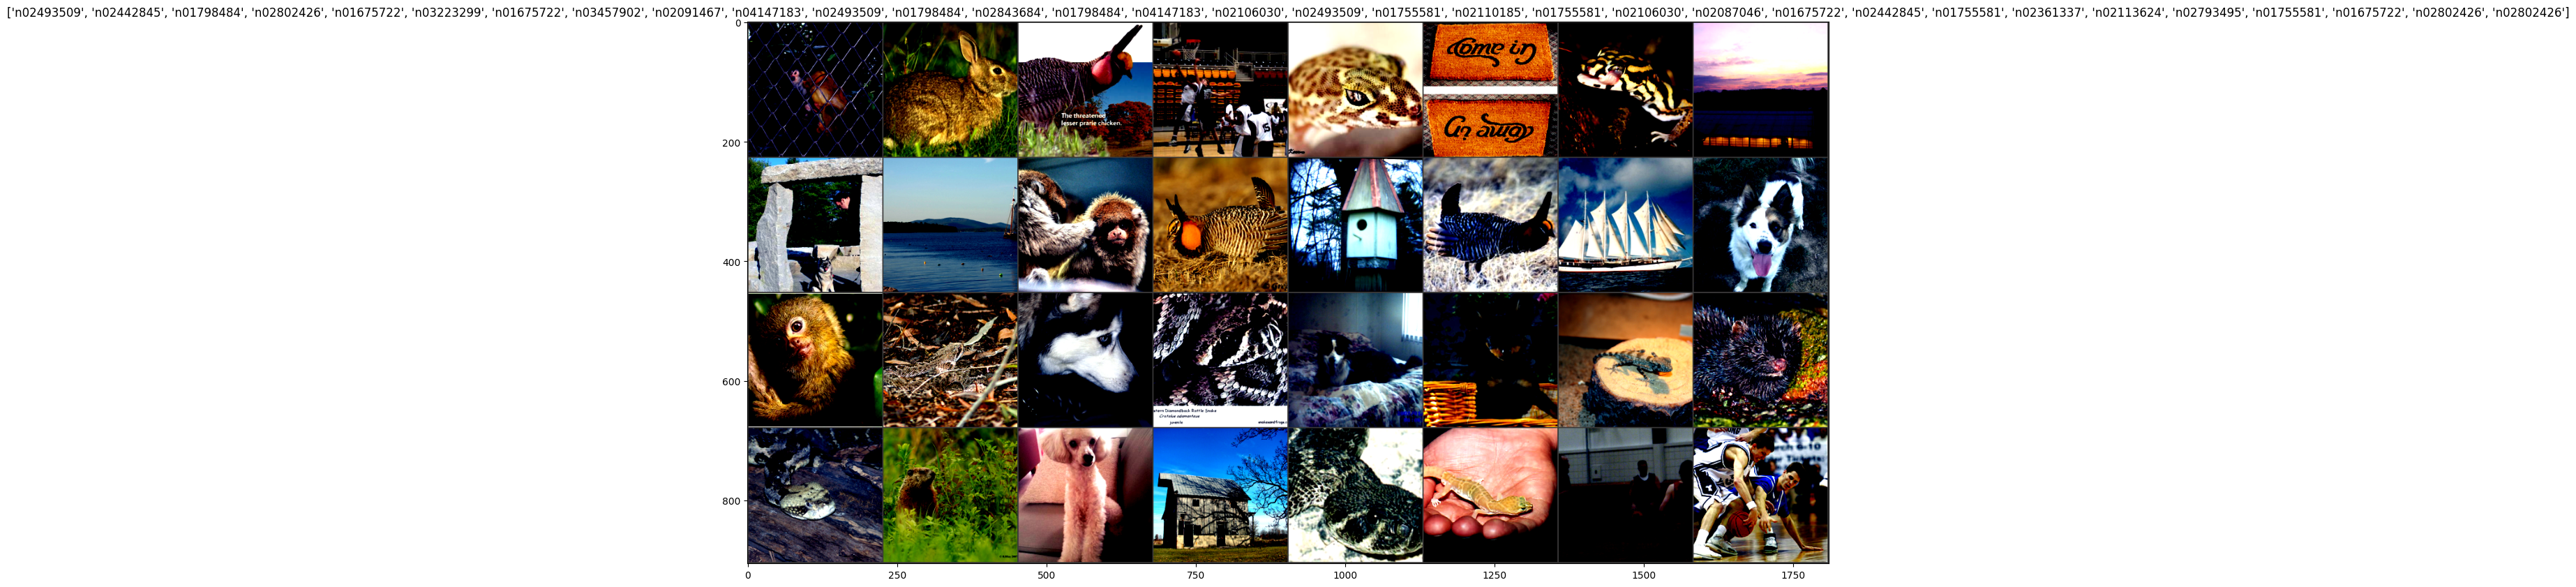

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std= torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    inp = inp * mean
    inp = inp + std
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.imsave("dataset_samples.png",inp)
    plt.show()
    with open("dataset_samples.txt", "w") as output:
        output.write(str(title))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,20))
imshow(out, title=[class_names[x] for x in classes])

#04

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = [];
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = running_corrects = 0
            # Iterate over data.
            cnt=0
            for inputs, labels in dataloaders[phase]:
                cnt += len(labels)
                with open("rnn_counters.txt", "w") as f:
                    f.write(f"{epoch}_{cnt}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(float(epoch_loss))
                hist_acc_train.append(float(epoch_acc.cpu()))
            else:
                hist_loss_val.append(float(epoch_loss))
                hist_acc_val.append(float(epoch_acc.cpu()))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = float(epoch_acc.cpu())
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        # print()
        clear_output(True)
        print(f"epoch:{epoch} time:{(time.time() - since)/(epoch+1):.1f} acc:{hist_acc_val[-1]:.4f}")
        fig=plt.figure()
        plt.plot(np.arange(0,epoch+1),hist_loss_train,label='hist_loss_train')
        plt.plot(np.arange(0,epoch+1),hist_loss_val,label='hist_loss_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss')
        plt.show()
        plt.plot(np.arange(0,epoch+1),hist_acc_train,label='hist_acc_train')
        plt.plot(np.arange(0,epoch+1),hist_acc_val,label='hist_acc_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.show()
        # torch.save(model, f'rnn_conv_{epoch}.pth')
        torch.save(model, f'alexnet_{len(class_names)}.pth')
        
    model.eval()
    time_elapsed = time.time() - since
    
    dict_hist={
        "hist_loss_train": hist_loss_train,
        "hist_acc_train": hist_acc_train,
        "hist_loss_val": hist_loss_val,
        "hist_acc_val": hist_acc_val
    }
    # load best model weights
    model.load_state_dict(best_model_wts)
    model.eval()
    return model,best_acc,time_elapsed,fig,dict_hist

In [8]:
def prep_alexnet():
    if os.path.isfile(f'alexnet_{len(class_names)}.pth'):
        model_ft = torch.load(f'alexnet_{len(class_names)}.pth')
        print(f'Model alexnet_{len(class_names)}.pth loaded')
    else:
        model_ft = models.alexnet(pretrained=False)
        num_ftrs = len(list(model_ft.parameters())[-3])
        model_ft.classifier[-1] = Sequential(Linear(num_ftrs,len(class_names)))
        print(f'Model alexnet_{len(class_names)}.pth created')
    return model_ft.to(device),'alexnet'

In [9]:
model_ft,_=prep_alexnet()

/tmp/ipykernel_57846/133266806.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft = torch.load(f'alexnet_{len(class_names)}.pth')


Model alexnet_20.pth loaded


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

epoch:34 time:68.5 acc:0.6450


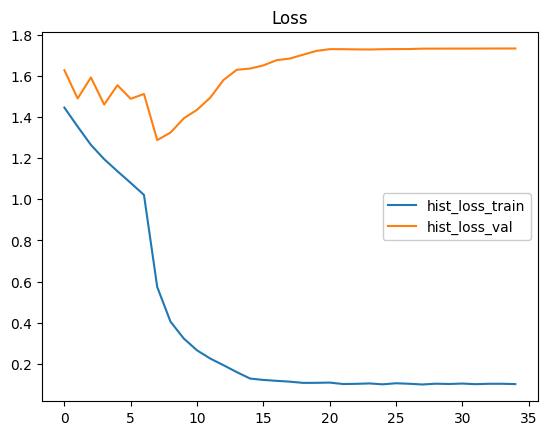

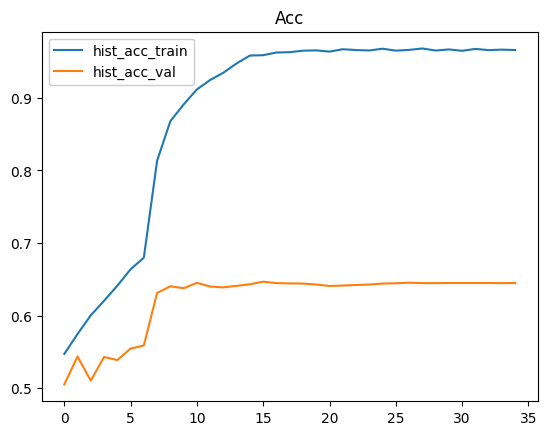

In [12]:
model,best_acc,time_elapsed,fig,dict_hist = train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler,num_epochs=35)